Check if saving and everything else has been correctly done after run the script for prestim later none filter on eCortex

In [107]:
import mne
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from mne.datasets import sample
from mne.decoding import cross_val_multiscore, LinearModel, GeneralizingEstimator, Scaler, \
                         Vectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedShuffleSplit, \
                                    RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import argparse

import pickle

# Set args

In [108]:
class arguments():
    SAVE_EPOCH_ROOT = '../../data/version5.2/preprocessed/epochs/aft_ICA_rej/'
    SAVE_RESULT_ROOT = '../../results/temp_gen/eCortex/'
    cond_filter ='none' # {none,non_symm}
    cond_block ='later' #{early,later}
    cond_time = 'prestim' #{prestim,poststim}
    cond_decoding = 'none' #{none,removeevoked,resampled}
    subj_num = 1
    applyBaseline_bool = 'False'
    pre_tmin = -0.4
    pre_tmax = 0.05
    post_tmin = 0.05
    post_tmax = 0.45
    num_classes = 2
    normalization_type = 'normal'# {normal,lstmPaper}
    gen_rand_perm = 0
    null_max_iter = 10000
    loop_null_iter = 5
    gen_decoder_scores = 1
    n_splits = 5
    random_state = 42 
    max_iter = 10000
    n_jobs = 1
    scoring = 'roc_auc'
    
args = arguments()

In [109]:
if args.applyBaseline_bool:
    filename_epoch = args.SAVE_EPOCH_ROOT + \
                     'epochs_sec_applyBaseline_subj%s-afterRejICA-epo.fif' \
                      %args.subj_num
else:
    filename_epoch = args.SAVE_EPOCH_ROOT + \
                     'epochs_sec_subj%s-afterRejICA-epo.fif' \
                     %args.subj_num
epochs_orig = mne.read_epochs(filename_epoch, proj=True, preload=True,
                              verbose=None)
epochs = epochs_orig.copy()
subset = epochs['pred']['non'].copy()
subset = subset.pick_types(eeg=True)
if (args.cond_decoding=='removeevoked'):
    # REMOVE EVOKED RESP.
    subset.subtract_evoked()    # remove evoked response
elif (args.cond_decoding=='resampled'):
    # RESAMPLE
    subset = subset.resample(args.n_resampling, npad='auto')
else:
    pass
##==========================================================================
if subset['Block==7'].metadata.Ptrn_Type.values.shape[0]>0:
   main_ptrn = subset['Block==7'].metadata.Ptrn_Type.values[0]
else:
   main_ptrn = subset['Block==8'].metadata.Ptrn_Type.values[0]
##==========================================================================
if args.cond_block=='early': #block 3-6
    subset = subset['Block<7'].copy()
    subset = subset['Block>2'].copy()
elif args.cond_block=='later':#block 7-10
    subset = subset['Block<11'].copy()
    subset = subset['Block>6'].copy()
##==========================================================================
subset = subset.crop(tmin=-0.45, tmax=0.45)
# if (args.cond_time=='prestim'):
#     subset= subset.crop(tmin=-0.4, tmax=0.05)
# if (args.cond_time=='poststim'):
#     subset= subset.crop(tmin=0.05, tmax=0.45)
print('Shape of data is\n :')
print(subset._data.shape)

Reading ../../data/version5.2/preprocessed/epochs/aft_ICA_rej/epochs_sec_applyBaseline_subj1-afterRejICA-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 129) active
    Found the data of interest:
        t =    -400.00 ...    5000.00 ms
        0 CTF compensation matrices available
1197 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1197 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 16 columns
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Shape of data is
 :
(357, 129, 213)


<ipython-input-109-9b9e9731df0e>:31: RuntimeWarning: tmin is not in epochs time interval. tmin is set to epochs.tmin
  subset = subset.crop(tmin=-0.45, tmax=0.45)


# Plot functions

In [5]:
def smooth(y, window, mode):
    box = np.ones(window)/window
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def plot_scores(scores):
    fig, ax = plt.subplots(1, 1)
    plt.tight_layout()
    im = ax.imshow(scores, interpolation='lanczos', origin='lower', cmap='RdBu_r',
                   extent=subset.times[[0, -1, 0 , -1]], vmin=0., vmax=1.)
    ax.set_xlabel('Testing Time (s)')
    ax.set_ylabel('Training Time (s)')
    ax.set_title('Temporal generalization')
    ax.axvline(0, color='k')
    ax.axhline(0, color='k')
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

def plot_scores_diag(scores_diag, apply_smooth):
    if apply_smooth:
        window=50
        mode='valid'
        scores_diag = smooth(y, window, mode)
        print(subset.times.shape)
        print(y_smooth.shape)
    fig, ax = plt.subplots()
    ax.plot(subset.times, scores_diag, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding')
    plt.tight_layout()
    plt.show()

# Statistical analysis

## Plot functions

In [6]:
def do_time_bin(data, indx, sbt):
    if sbt==0:
        avgs=np.zeros(len(indx))
        bs=np.array(np.split(data, indx))
        for ii in range(len(indx)):
            avgs[ii]=bs[ii].mean()
    if sbt==1:
         avgs=np.zeros([data.shape[0],len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs=np.array(np.split(data[jj,:], indx))
             for ii in range(len(indx)):
                 aa[ii]=bs[ii].mean()
             avgs[jj,:]=aa
    if sbt==2:
         avgs=np.zeros([len(indx),len(indx)])
         aa=np.zeros(len(indx))
         for jj in range(data.shape[0]):
             bs1=np.array(np.split(data[jj,:], indx))
             bs2=np.array(np.split(data[:,jj], indx))
             for ii in range(len(indx)):
                 avgs[ii,:]=bs1[ii].mean()
                 avgs[:,ii]=bs2[ii].mean()

    return avgs

In [7]:
def set_fonts():
    font = FontProperties()
    font.set_family('serif')
    font.set_name('Calibri')
    return font

def plot_scores_stat(diag_scores, clusts):
    font=set_fonts();
    [t_obs, clusters, clusters_pv, H0] = clusts
    # binned times
    times=np.asarray([-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4])
    extent_times=subset.times[[0, -1, 0, -1]]
    
    # Plot the diagonal (it's exactly the same as the time-by-time decoding above)
    fig, ax = plt.subplots()
    plt.tight_layout()
    ax.plot(times, diag_scores, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    plt.ylim([0.43,0.65])
    ax.axvline(.0, color='k', linestyle='-')

    for i_clu, clu_idx in enumerate(clusters):
        clu_idx=clu_idx[0]
        print(clu_idx)
        # unpack cluster information, get unique indices
        if clusters_pv[i_clu] <= 0.05:
            h = plt.axvspan(times[clu_idx[0]], times[clu_idx[-1] - 1],
                            color='r', alpha=0.3)
            plt.legend((h, ), ('cluster p-value < 0.05', ))
        else:
            plt.axvspan(times[clu_idx[0]], times[clu_idx[-1] - 1], color=(0.3, 0.3, 0.3),
                        alpha=0.3)

    plt.tight_layout()
    plt.xlabel('Times',  fontproperties=font, fontsize=12, fontweight='bold')
    plt.ylabel('AUC', fontproperties=font, fontsize=12, fontweight='bold')#, labelpad=16,)
    plt.title('Decoding over time', fontproperties=font, fontweight='bold', fontsize=16)

    plt.legend(fontsize=11)
    plt.tight_layout()

## Statistical analysis

In [8]:
def stat_anal(scores_pck):
    indx=[26,51,76,101,126,151,176,201]
    
    score, score_diag = scores_pck
    score_subtract = score_diag - 0.5
    
    binned_score = do_time_bin(score, indx, 2)
    binned_score_diag = do_time_bin(score_diag, indx, 0)
    binned_score_subtract = do_time_bin(score_subtract, indx, 0)
    
    print(score_subtract.shape)
    score_subtract=score_subtract[:, np.newaxis, np.newaxis] # [:,:, np.newaxis] when added more subjects
    
    print(score_subtract.shape)
    t_obs, clusters, clusters_pv, H0 = mne.stats.spatio_temporal_cluster_1samp_test(score_subtract, tail=0)
    
    clust_pck = [t_obs, clusters, clusters_pv, H0]
    
    return binned_score_diag, clust_pck

# load nested list results using pickle

In [9]:
main_ptrn=1

fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_Subj_%s' \
            %(args.cond_block, args.cond_filter, args.subj_num)
fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj

fn_str

'../../results/temp_gen/eCortex/avgP1_scores_timeGen_laterBlocks_noneFilter_Subj_1'

In [15]:
#removed subj 25
# no avgP1_scores_timeGen_laterBlocks_noneFilter_PrePost_decodnone_bslineFalse_Subj_42
# subj_indx = [ 1,  2,  3,  4,  5,  7,  8,  9, 10, 12, 15, 16, 17, 18, 19, 20, 21,
#        22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
#        39, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 55, 56, 57, 58, 59,
#        60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]

# selected_subj = [subj_indx[0], subj_indx[29], subj_indx[30], subj_indx[35],\
#                  subj_indx[49], subj_indx[60], 15, 21, 48]
# 44 people p1 and 22 people p2
# selected_subj_P1 = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15, 16, 17, 42, 43, 44, 45, 47, \
#                     48, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, \
#                     66, 67, 68, 69, 70, 71, 72, 73, 74]
# selected_subj_P2 = [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,\
#                     33, 34, 35, 36, 37, 38, 39]


In [102]:
selected_subj_P1 = [1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 15, 16, 17]
selected_subj_P2 = [18, 19, 20, 21, 22, 23, 24, 25, 33]

# selected_subj_P1 = [42, 43, 44, 45, 47,48, 51, 52, 53, 55, 56, 57, 58, 59, 60, \
#                     61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74]
# selected_subj_P2 = [6, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]

In [103]:
#sc_subj_pck = [avg_sc, avg_diag_sc, avg_sc_fit, avg_diag_sc_fir]

avgp1_sc=[]
avgp2_sc=[]
avgp1_diag=[]
avgp2_diag=[]

avgp1_sc_fit=[]
avgp2_sc_fit=[]
avgp1_diag_fit=[]
avgp2_diag_fit=[]

for subj_id in selected_subj_P1:
    main_ptrn = 1
    args.subj_num = subj_id

    fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, args.cond_decoding, \
                  args.applyBaseline_bool, args.subj_num)
    fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj
    with open(fn_str, 'rb') as f:
        sc_subj_pck = pickle.load(f)

    avgp1_sc.append(sc_subj_pck[0])
    avgp1_diag.append(sc_subj_pck[1])

    avgp1_sc_fit.append(sc_subj_pck[2])
    avgp1_diag_fit.append(sc_subj_pck[3])

for subj_id in selected_subj_P2:
    main_ptrn = 2
    args.subj_num = subj_id

    fn_str_sbj='scores_timeGen_%sBlocks_%sFilter_PrePost_decod%s_bsline%s_Subj_%s' \
                %(args.cond_block, args.cond_filter, args.cond_decoding, \
                  args.applyBaseline_bool, args.subj_num)
    
    fn_str = args.SAVE_RESULT_ROOT + 'avgP%s_' %(main_ptrn) + fn_str_sbj
    with open(fn_str, 'rb') as f:
        sc_subj_pck = pickle.load(f)


    avgp2_sc.append(sc_subj_pck[0])
    avgp2_diag.append(sc_subj_pck[1])

    avgp2_sc_fit.append(sc_subj_pck[2])
    avgp2_diag_fit.append(sc_subj_pck[3])

print(np.asarray(avgp1_diag).shape)
print(np.asarray(avgp2_diag).shape)

(13, 213)
(9, 213)


In [104]:
p1=np.asarray(avgp1_sc)
p2=np.asarray(avgp2_sc)
p=np.concatenate((p1, p2), axis=0)
avgP = np.mean(p, axis=0)

p1d=np.asarray(avgp1_diag)
p2d=np.asarray(avgp2_diag)
pd=np.concatenate((p1d, p2d), axis=0)
avgPdiag = np.mean(pd, axis=0)

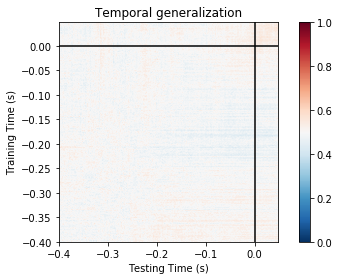

ValueError: x and y must have same first dimension, but have shapes (113,) and (213,)

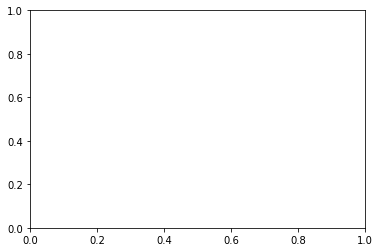

In [105]:
plot_scores(avgP)
plot_scores_diag(avgPdiag, 0)